<a href="https://colab.research.google.com/github/min207/2023-1-ESAA/blob/main/ESAA20602_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library 

In [9]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("/content"))

['.config', 'test', '.ipynb_checkpoints', 'train', 'sample_data']


# Define Constants

In [10]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Training Data

In [11]:
filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [12]:
df.head()

filename  category
0  dog.499.jpg         1
1  dog.508.jpg         1
2  cat.360.jpg         0
3  dog.144.jpg         1
4  dog.418.jpg         1

In [13]:
df.tail()

filename  category
1397  dog.484.jpg         1
1398  cat.696.jpg         0
1399  cat.114.jpg         0
1400  dog.112.jpg         1
1401  cat.258.jpg         0

- see tatal in count

<Axes: >

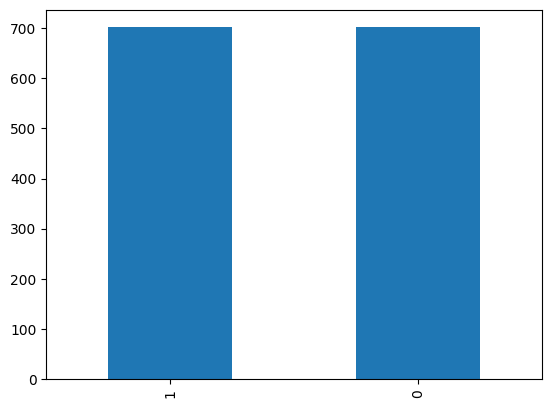

In [14]:
df['category'].value_counts().plot.bar()

# See sample image

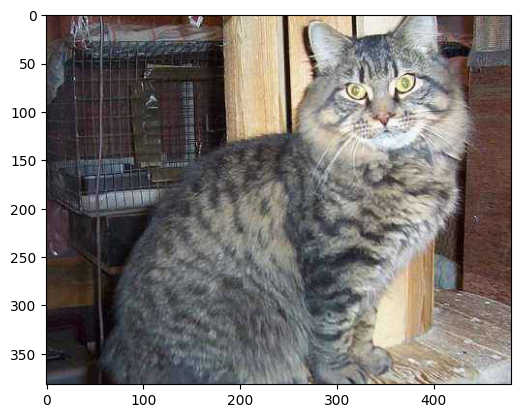

In [15]:
sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)

# Build Model

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

# Callbacks

In [17]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

- Early Stop

In [18]:
earlystop = EarlyStopping(patience=10)

- Learning Rate Reduction

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [20]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

In [21]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [22]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

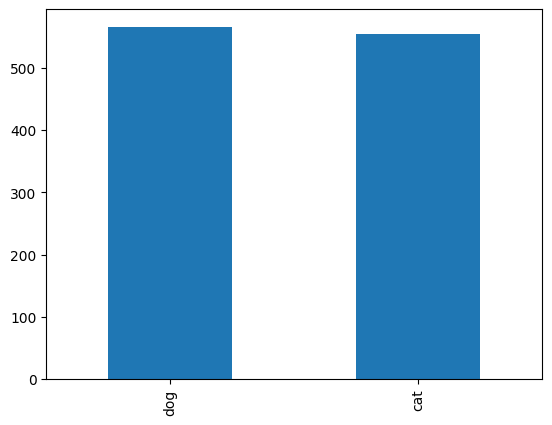

In [23]:
train_df['category'].value_counts().plot.bar()

<Axes: >

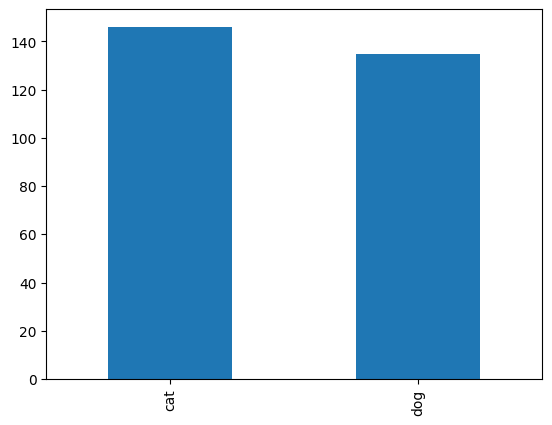

In [24]:
validate_df['category'].value_counts().plot.bar()

In [25]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Training Generator

In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1121 validated image filenames belonging to 2 classes.


- Validation Generator

In [27]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 281 validated image filenames belonging to 2 classes.


# See how our generator work

In [28]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


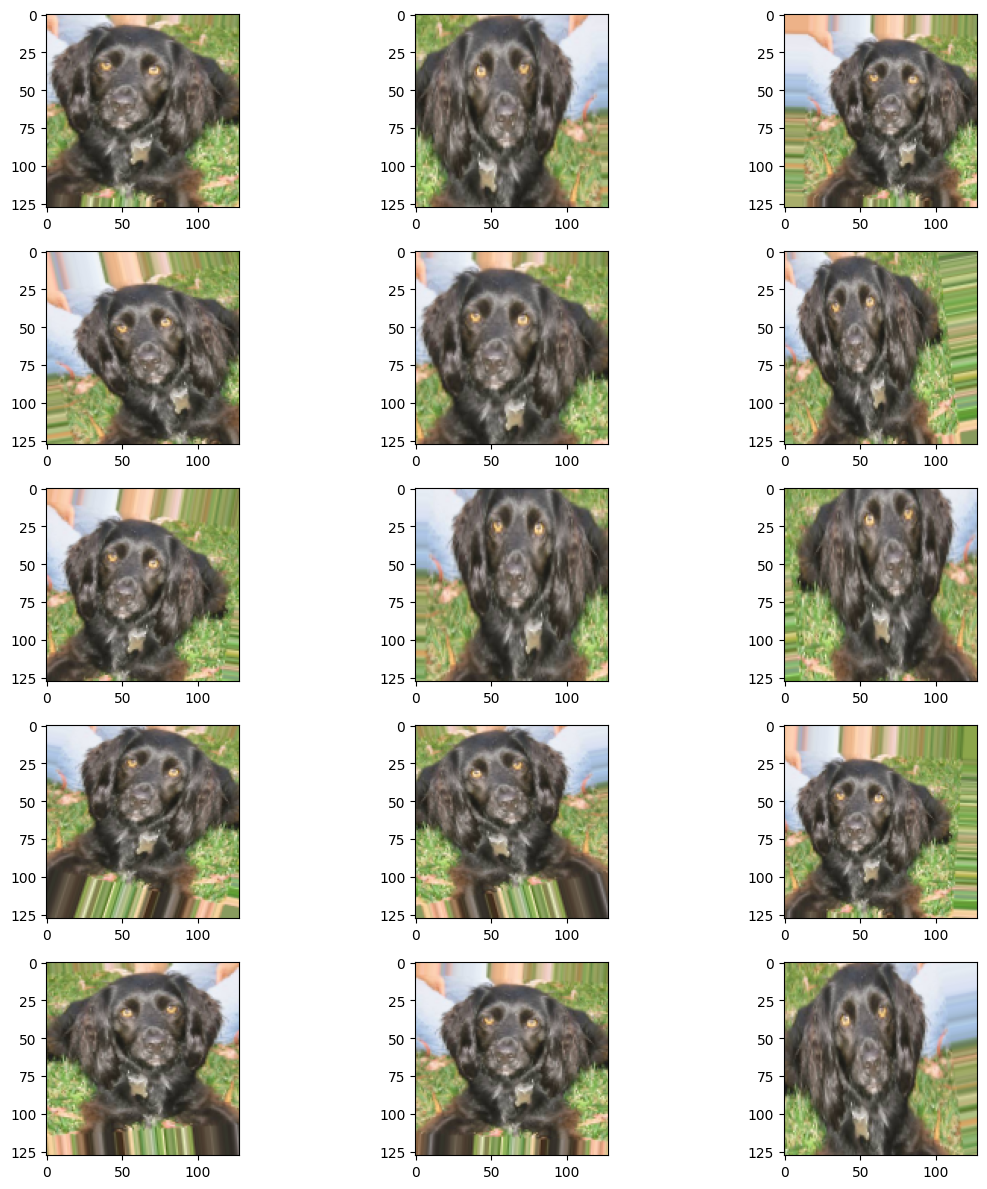

In [29]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()


# Fit Model

In [30]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-30-63cb34b6e89a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.4712 - accuracy: 0.5425

74/74 [==============================] - 76s 1s/step - loss: 1.4712 - accuracy: 0.5425 - val_loss: 1.4506 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 1.0846 - accuracy: 0.5588

74/74 [==============================] - 76s 1s/step - loss: 1.0846 - accuracy: 0.5588 - val_loss: 1.7529 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.8355 - accuracy: 0.5931

74/74 [==============================] - 74s 1s/step - loss: 0.8355 - accuracy: 0.5931 - val_loss: 1.5484 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/50
74/74 [==============================] - ETA: 0s - loss: 0.7385 - accuracy: 0.6347

74/74 [==============================] - 76s 1s/step - loss: 0.7385 - accuracy: 0.6347 - val_loss: 0.7692 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 5/50
74/74 [==============================] - ETA: 0s - loss: 0.7546 - accuracy: 0.6257

74/74 [==============================] - 74s 1s/step - loss: 0.7546 - accuracy: 0.6257 - val_loss: 1.9868 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 6/50
74/74 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.6591

74/74 [==============================] - 75s 1s/step - loss: 0.6590 - accuracy: 0.6591 - val_loss: 0.7287 - val_accuracy: 0.6296 - lr: 0.0010
Epoch 7/50
74/74 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.6691

74/74 [==============================] - 76s 1s/step - loss: 0.6356 - accuracy: 0.6691 - val_loss: 0.5884 - val_accuracy: 0.7037 - lr: 0.0010
Epoch 8/50
74/74 [==============================] - ETA: 0s - loss: 0.6252 - accuracy: 0.6971

74/74 [==============================] - 75s 1s/step - loss: 0.6252 - accuracy: 0.6971 - val_loss: 0.5871 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 9/50
74/74 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.6935

74/74 [==============================] - 79s 1s/step - loss: 0.6137 - accuracy: 0.6935 - val_loss: 0.6689 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 10/50
74/74 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.7197

74/74 [==============================] - 78s 1s/step - loss: 0.5997 - accuracy: 0.7197 - val_loss: 0.5803 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 11/50
74/74 [==============================] - ETA: 0s - loss: 0.5894 - accuracy: 0.7052

74/74 [==============================] - 77s 1s/step - loss: 0.5894 - accuracy: 0.7052 - val_loss: 0.6697 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 12/50
74/74 [==============================] - ETA: 0s - loss: 0.5744 - accuracy: 0.7188

74/74 [==============================] - 73s 990ms/step - loss: 0.5744 - accuracy: 0.7188 - val_loss: 0.7860 - val_accuracy: 0.5630 - lr: 0.0010
Epoch 13/50
74/74 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.7260

74/74 [==============================] - 77s 1s/step - loss: 0.5465 - accuracy: 0.7260 - val_loss: 0.4984 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 14/50
74/74 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.7523

74/74 [==============================] - 77s 1s/step - loss: 0.5470 - accuracy: 0.7523 - val_loss: 0.8458 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 15/50
74/74 [==============================] - ETA: 0s - loss: 0.5501 - accuracy: 0.7468

74/74 [==============================] - 75s 1s/step - loss: 0.5501 - accuracy: 0.7468 - val_loss: 0.6832 - val_accuracy: 0.6815 - lr: 0.0010
Epoch 16/50
74/74 [==============================] - ETA: 0s - loss: 0.5291 - accuracy: 0.7468

74/74 [==============================] - 76s 1s/step - loss: 0.5291 - accuracy: 0.7468 - val_loss: 0.6820 - val_accuracy: 0.6778 - lr: 0.0010
Epoch 17/50
74/74 [==============================] - ETA: 0s - loss: 0.5325 - accuracy: 0.7378

74/74 [==============================] - 77s 1s/step - loss: 0.5325 - accuracy: 0.7378 - val_loss: 0.7157 - val_accuracy: 0.6481 - lr: 0.0010
Epoch 18/50
74/74 [==============================] - ETA: 0s - loss: 0.4892 - accuracy: 0.7604

74/74 [==============================] - 75s 1s/step - loss: 0.4892 - accuracy: 0.7604 - val_loss: 0.5500 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 19/50
74/74 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.7685

74/74 [==============================] - 75s 1s/step - loss: 0.4969 - accuracy: 0.7685 - val_loss: 0.5379 - val_accuracy: 0.7481 - lr: 0.0010
Epoch 20/50
74/74 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.7785

74/74 [==============================] - 74s 1s/step - loss: 0.4858 - accuracy: 0.7785 - val_loss: 0.5938 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 21/50
74/74 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.7667

74/74 [==============================] - 73s 981ms/step - loss: 0.5057 - accuracy: 0.7667 - val_loss: 0.6309 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 22/50
74/74 [==============================] - ETA: 0s - loss: 0.4802 - accuracy: 0.7640

74/74 [==============================] - 73s 985ms/step - loss: 0.4802 - accuracy: 0.7640 - val_loss: 0.5169 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 23/50
74/74 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.7857

74/74 [==============================] - 74s 1s/step - loss: 0.4684 - accuracy: 0.7857 - val_loss: 0.6427 - val_accuracy: 0.6630 - lr: 0.0010


# Save Model

In [31]:
model.save_weights("model.h5")

# Virtualize Training

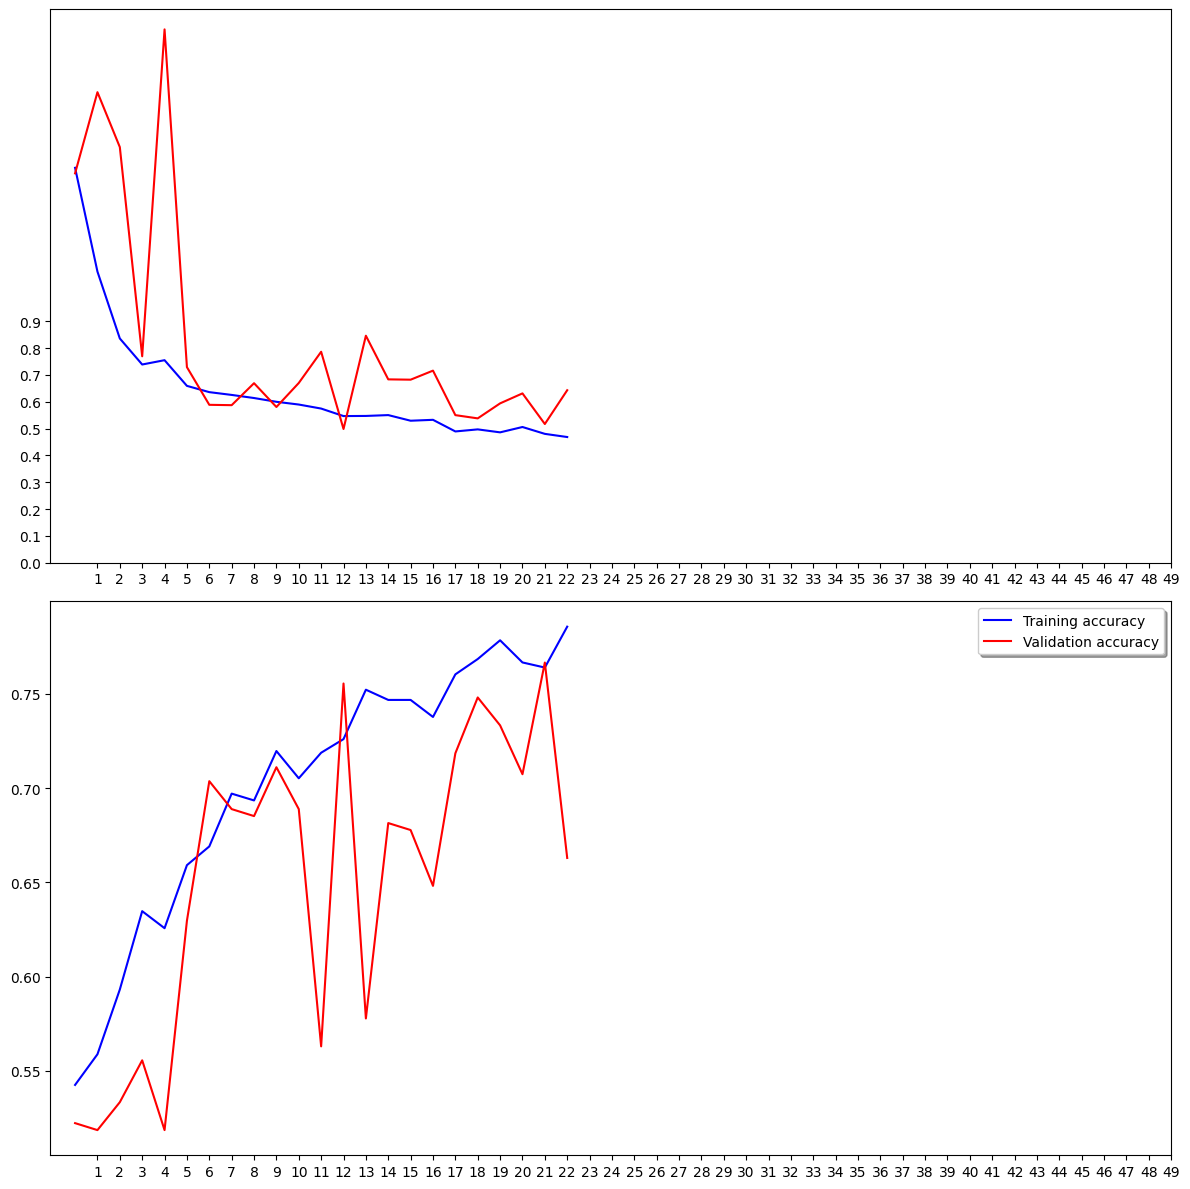

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [33]:
test_filenames = os.listdir("/content/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [34]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


# Predict

In [35]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-35-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [36]:
test_df['category'] = np.argmax(predict, axis=-1)

In [37]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [38]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

- virtualize result

<Axes: >

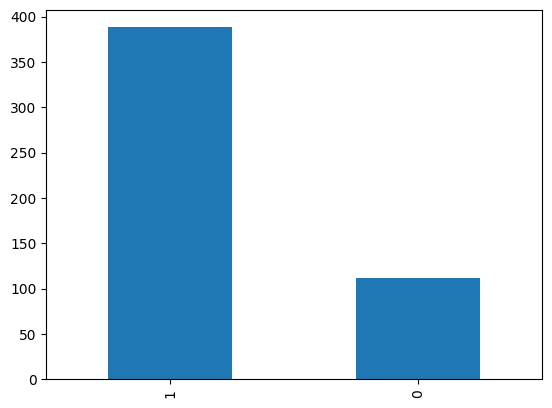

In [39]:
test_df['category'].value_counts().plot.bar()

- see predictd result with images

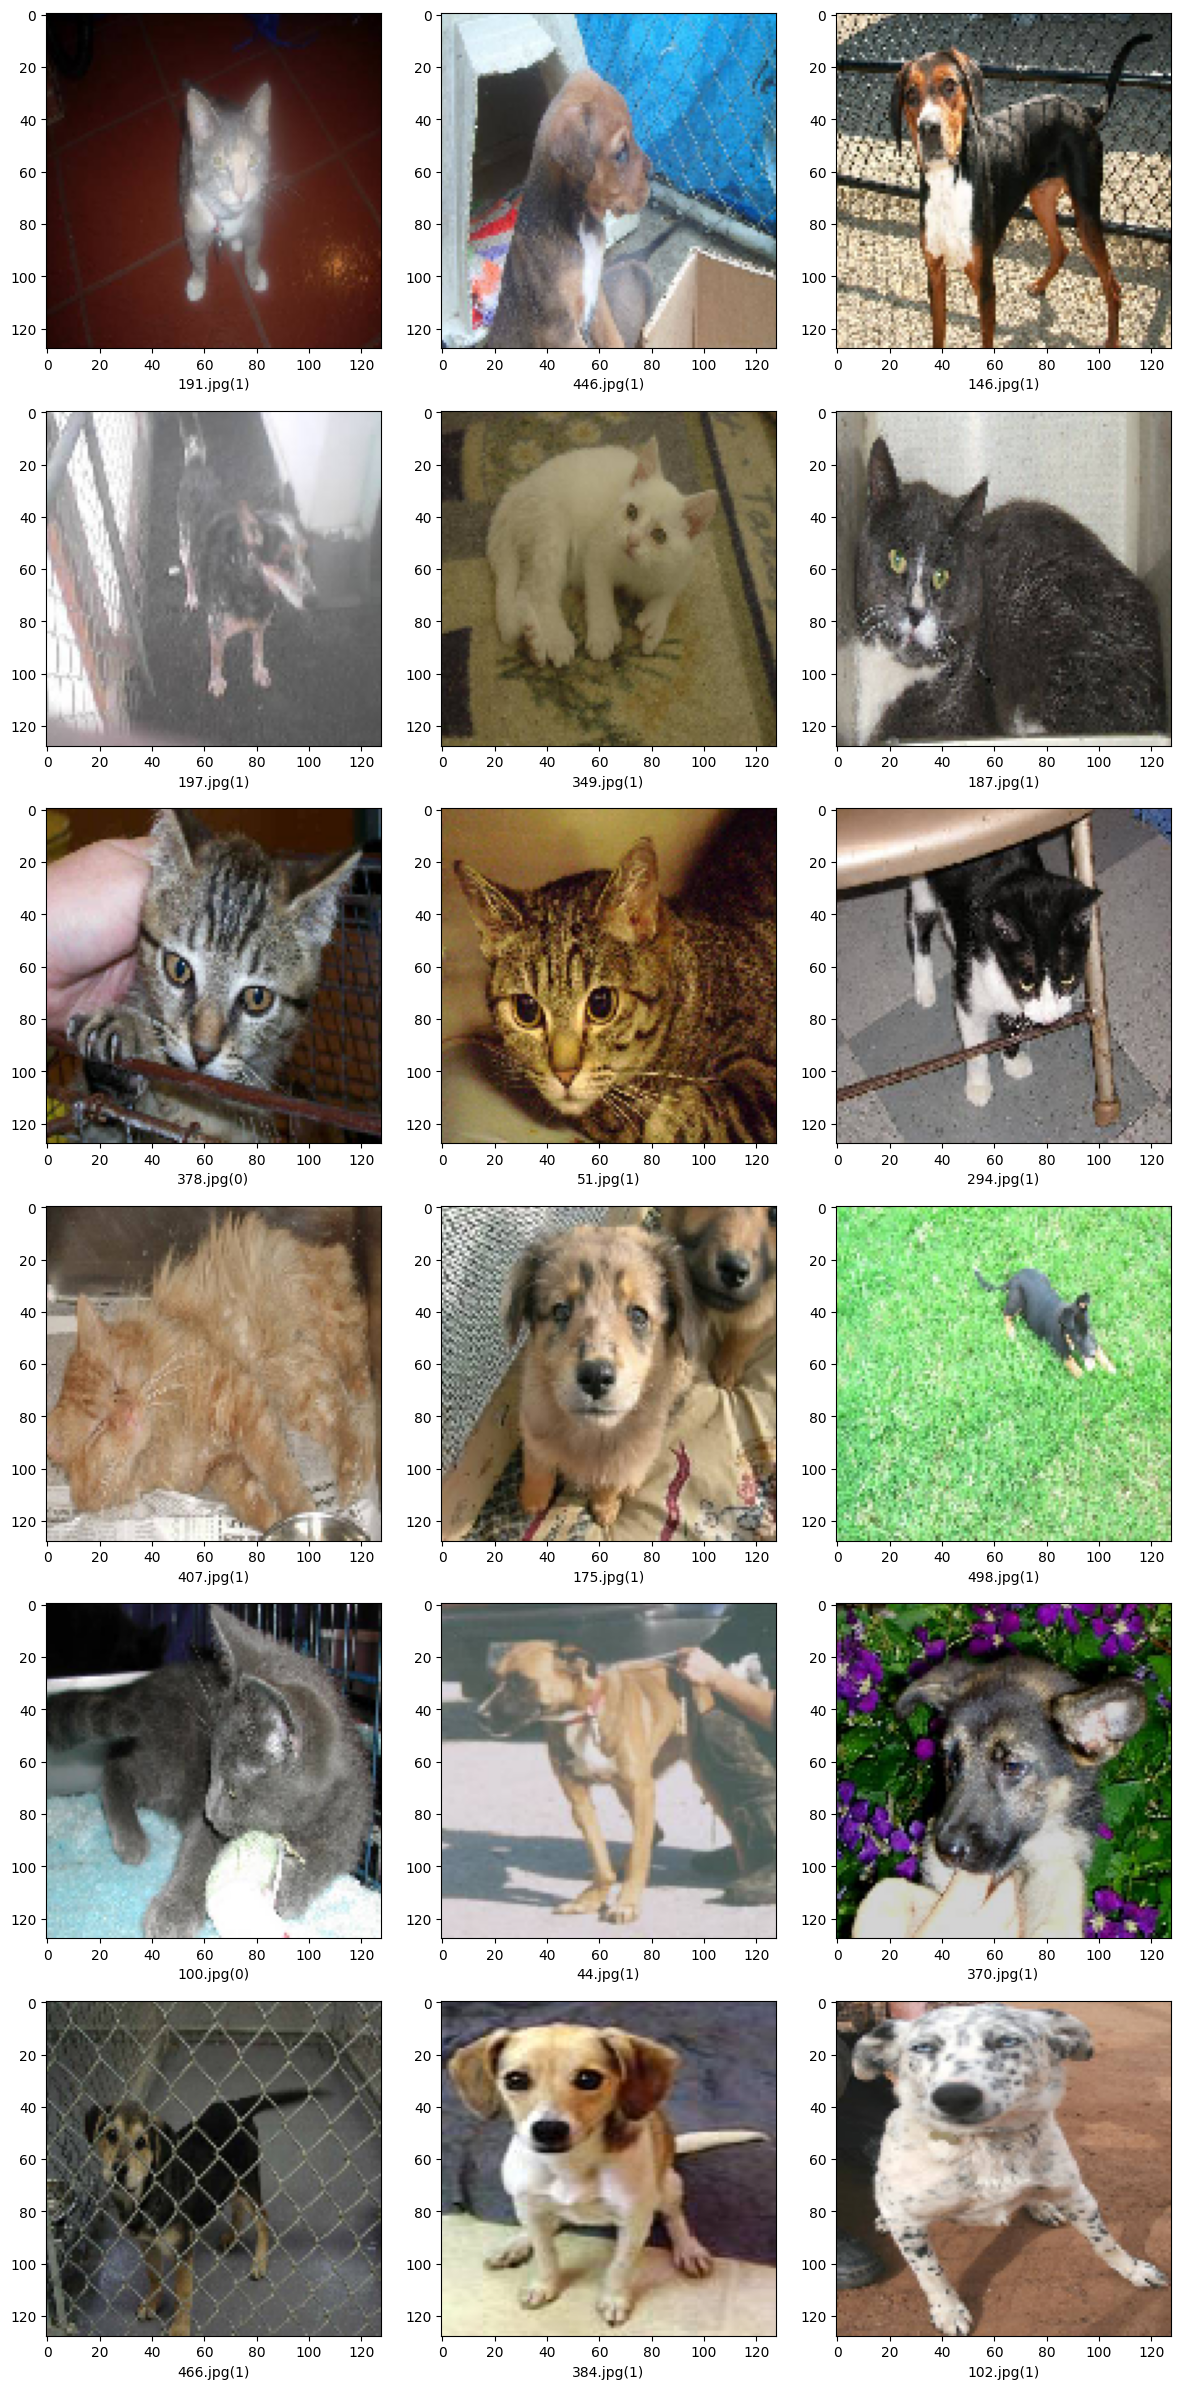

In [40]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()